This notebook is for training and word2vec.

#### 1. Import Libraries
The first cell imports libraries. This code uses Tensorflow version 0.9. If Tensorflow version is not the same, the code may not work as expected.
Make sure Tensorflow environment is on before starting this notebook.

```
> source activate tensorflow
```

Some libraries need to be install after Tensorflow enviroment starts.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import os
import random
import time
from six.moves import cPickle

import numpy as np
import tensorflow as tf
from tensorflow.python.ops import rnn

%matplotlib inline
from matplotlib import pylab
from sklearn.manifold import TSNE

logging = tf.logging

#### 2. Input data processing functions
The next part is function definitions to read and prepare data for learning.

In [2]:
def _read_words(filename):
    "Given a filename, returns a list of words, which are separated by a space."
    with tf.gfile.GFile(filename, "r") as f:
        return f.read().decode("utf-8").replace("\n", " ").split()

def _build_vocab(data):
    "Given data (a list of words), returns a sorted words list and dictionary of word/frequency pairs."
    counter = collections.Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id

def _file_to_word_ids(data, word_to_id):
    "Given data (a list of words) and dictionary of word/frequency pairs, returns a list of words' index."
    return [word_to_id[word] for word in data if word in word_to_id]

#### 3. Model definition
This is a model definition. The model uses LSTM (long short term memory) cell, which is stacked up by config.num_layers.

In [3]:
class Model(object):
    """Model definition"""

    def __init__(self, is_training, config):
        self.batch_size = batch_size = config.batch_size
        self.num_steps = num_steps = config.num_steps
        hidden_size = config.hidden_size
        vocab_size = config.vocab_size

        self._input_data = tf.placeholder(tf.int32, [batch_size, num_steps])
        self._targets = tf.placeholder(tf.int32, [batch_size, num_steps])

        # gets LSTM cell
        print("Forget bais: %.3f" % config.forget_bias)
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_size, forget_bias=config.forget_bias)
        # dropout setting, increase/decrease number of neurons
        if is_training and config.keep_prob < 1:
            lstm_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_cell,
                                                      output_keep_prob=config.keep_prob)
        # stacks up cells
        if config.num_layers == 0:
            print("Basic LSTM Cell")
            self._cell = cell = lstm_cell
        else:
            print("Multi RNN Cell of " + str(config.num_layers))
            self._cell = cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * config.num_layers)

        self._initial_state = cell.zero_state(batch_size, tf.float32)

        # looks up embeddings and gets input
        with tf.device("/cpu:0"):
            embedding = tf.get_variable("embedding", [vocab_size, hidden_size])
            inputs = tf.nn.embedding_lookup(embedding, self._input_data)

        # calculates dropouts.
        if is_training and config.keep_prob < 1:
            # the second argument is a probablitiy of keep_prob.
            # outputs will be scaled by 1/keep_prob.
            inputs = tf.nn.dropout(inputs, config.keep_prob)

        state = self._initial_state
        with tf.variable_scope("RNN"):
            x = [tf.squeeze(input_, [1]) for input_ in tf.split(1, num_steps, inputs)]
            # updates a state and computes outputs
            outputs, state = rnn.rnn(cell, x, initial_state=state)

        output = tf.reshape(tf.concat(1, outputs), [-1, hidden_size])
        # softmax of weights
        softmax_w = tf.get_variable("softmax_w", [hidden_size, vocab_size])
        # softmax of bias
        softmax_b = tf.get_variable("softmax_b", [vocab_size])
        # caclulates y = Wx + b (score y is called logits)
        logits = tf.matmul(output, softmax_w) + softmax_b
        # computes softmax cross entropy loss of batch_size
        loss = tf.nn.seq2seq.sequence_loss_by_example(
            [logits],
            [tf.reshape(self._targets, [-1])],
            [tf.ones([batch_size * num_steps])])
        # gets scalar value of normalized loss
        self._cost = cost = tf.reduce_sum(loss) / batch_size
        self._final_state = state
        self._probs = tf.nn.softmax(logits)

        if not is_training:
            return

        self._lr = tf.Variable(0.0, trainable=False)
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars),
                                          config.max_grad_norm)
        # optimazation
        optimizer = tf.train.GradientDescentOptimizer(self.lr)
        self._train_optimizer = optimizer.apply_gradients(zip(grads, tvars))
        
        # updates embeddings. computes similarity based on cosine distance
        norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
        self._normalized_embeddings = embedding / norm


    def assign_lr(self, session, lr_value):
        session.run(tf.assign(self.lr, lr_value))

    @property
    def input_data(self):
        return self._input_data

    @property
    def targets(self):
        return self._targets

    @property
    def initial_state(self):
        return self._initial_state

    @property
    def cost(self):
        return self._cost

    @property
    def cell(self):
        return self._cell

    @property
    def final_state(self):
        return self._final_state

    @property
    def probs(self):
        return self._probs

    @property
    def lr(self):
        return self._lr

    @property
    def train_optimizer(self):
        return self._train_optimizer
    
    # sampling function to generate a sequence of words
    def sample(self, session, words, vocab, num=200, prime=' ', sampling_type=1):
        state = session.run(self.cell.zero_state(1, tf.float32))
        if not len(prime) or prime == " ":
            prime  = random.choice(list(vocab.keys()))    
        print (prime)
        for word in prime.split()[:-1]:
            print (word)
            x = np.zeros((1, 1))
            x[0, 0] = vocab.get(word,0)
            feed = {self.input_data: x, self.initial_state:state}
            [state] = session.run([self.final_state], feed)
         
        def weighted_pick(weights):
            t = np.cumsum(weights)
            s = np.sum(weights)
            return(int(np.searchsorted(t, np.random.rand(1)*s)))

        ret = prime
        word = prime.split()[-1]
        for n in range(num):
            x = np.zeros((1, 1))
            x[0, 0] = vocab.get(word,0)
            feed = {self.input_data: x, self.initial_state:state}
            [probs, state] = session.run([self.probs, self.final_state], feed)
            p = probs[0]

            if sampling_type == 0:
                sample = np.argmax(p)
            else: # sampling_type == 1 default:
                sample = weighted_pick(p)

            pred = words[sample]
            ret += ' ' + pred
            word = pred
        return ret

#### 4. Configurations
Config class defines configuration parameters.

In [4]:
class Config(object):
    init_scale = 0.1       # the initial random range of the weights
    learning_rate = 1.0    # the initial value of a learning rate
    max_grad_norm = 5      # the maximum permissible norm of the gradient
    num_layers = 3         # the number of LSTM layers
    num_steps = 20         # the number of unrolled steps of LSTM
    hidden_size = 200      # the number of LSTM units (neurons)
    forget_bias= 0.5       # the biases of the forget gate
    max_epoch = 6          # the number of epochs with the initial learning rate
    #max_max_epoch = 18     # the total number of epochs
    max_max_epoch = 1      # for debugging
    keep_prob = 0.5        # the probability of keeping weights in dropout layer
    lr_decay = 0.6         # the learning rate defay factor
    batch_size = 20        # the batch size

#### 5. Iteration functions
Function definitions to loop over input data and epoch (iteration of complete dataset) process.

In [5]:
def _next_batch(raw_data, batch_size, num_steps):
    """Returns data for the next batch"""
    raw_data = np.array(raw_data, dtype=np.int32)
    data_len = len(raw_data)
    batch_len = data_len // batch_size
    data = np.zeros([batch_size, batch_len], dtype=np.int32)
    for i in range(batch_size):
        data[i] = raw_data[batch_len * i:batch_len * (i + 1)]

    epoch_size = (batch_len - 1) // num_steps
    if epoch_size == 0:
        raise ValueError("epoch_size == 0, decrease batch_size or num_steps")

    for i in range(epoch_size):
        x = data[:, i*num_steps:(i+1)*num_steps]
        y = data[:, i*num_steps+1:(i+1)*num_steps+1]
        yield (x, y)

def run_epoch(session, m, data, eval_optimizer, verbose=False):
    """Runs the model on the given data."""
    epoch_size = ((len(data) // m.batch_size) - 1) // m.num_steps
    start_time = time.time()
    costs = 0.0
    iters = 0
    state = m.initial_state.eval()
    
    # creates SummaryWriter
    timestamp = str(current_milli_time())
    if not os.path.exists(os.path.join(save_dir, "summaries", timestamp)):
        os.makedirs(os.path.join(save_dir, "summaries", timestamp))
    train_summary_writer = tf.train.SummaryWriter(
        os.path.join(save_dir, "summaries", timestamp), session.graph)
    summary_op = tf.merge_all_summaries()
    
    for step, (batch_x, batch_y) in enumerate(_next_batch(data, m.batch_size, m.num_steps)):
        cost, state, _ = session.run([m.cost, m.final_state, eval_optimizer],
                                     {m.input_data: batch_x,
                                      m.targets: batch_y,
                                      m.initial_state: state})
        costs += cost
        iters += m.num_steps
        #train_summary_writer.add_summary(summary, step)

        if verbose and step % (epoch_size // 10) == 10:
            print("%.3f perplexity: %.3f speed: %.0f wps" % 
                  (step * 1.0 / epoch_size, np.exp(costs / iters),
                   iters * m.batch_size / (time.time() - start_time)))

    return np.exp(costs / iters)

#### 6. Preprocessing
Preparing input data, configuration and some more of utilities.

In [6]:
save_dir = "saved"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

current_milli_time = lambda: int(round(time.time() * 1000))

data_dir = "data"
train_path = os.path.join(data_dir, "train.txt")
valid_path = os.path.join(data_dir, "valid.txt")
test_path = os.path.join(data_dir, "test.txt")

data = _read_words(train_path)
words, word_to_id = _build_vocab(data)
train_data = _file_to_word_ids(data, word_to_id)
valid_data = _file_to_word_ids(_read_words(valid_path), word_to_id)
test_data = _file_to_word_ids(_read_words(test_path), word_to_id)
vocab_size = len(word_to_id)


config = Config()
config.vocab_size = vocab_size
test_config = Config()
test_config.vocab_size = vocab_size
test_config.batch_size = 1
test_config.num_steps = 1

#### 7. Training
The RNN starts running in this part. It will take log to finish the defined number of epoch.
When it completes, the training results will be saved in a file.

During the training, performace measurements will be displayed in the style of:

```
0.017 perplexity: 36138.733 speed: 525 wps
```

The first value shows how much data have been processed so far. The second value is the perplexity. The third value is a processing speed. 

In [7]:
with open(os.path.join(save_dir, 'words_vocab.pkl'), 'wb') as f:
    cPickle.dump((words, word_to_id), f)

train_perf = []
valid_perf = []
with tf.Graph().as_default(), tf.Session() as session:
    initializer = tf.random_uniform_initializer(-config.init_scale,
                                                config.init_scale)
    with tf.variable_scope("model", reuse=None, initializer=initializer):
        model = Model(is_training=True, config=config)
    with tf.variable_scope("model", reuse=True, initializer=initializer):
        validation_model = Model(is_training=False, config=config)
        test_model = Model(is_training=False, config=test_config)
    
    tf.initialize_all_variables().run()
    saver = tf.train.Saver()

    for i in range(config.max_max_epoch):
        lr_decay = config.lr_decay ** max(i - config.max_epoch, 0.0)
        model.assign_lr(session, config.learning_rate * lr_decay)

        print("Epoch: %d Learning rate: %.3f" % (i + 1, session.run(model.lr)))
        train_perplexity = run_epoch(session, model, train_data, model.train_optimizer, verbose=True)
        train_perf.append(train_perplexity)
        print("Epoch: %d Training   Perplexity: %.3f" % (i + 1, train_perplexity))
        valid_perplexity = run_epoch(session, validation_model, valid_data, tf.no_op())
        valid_perf.append(valid_perplexity)
        print("Epoch: %d Validation Perplexity: %.3f" % (i + 1, valid_perplexity))

    test_perplexity = run_epoch(session, test_model, test_data, tf.no_op())
    print("Test Perplexity: %.3f" % test_perplexity)
    
    final_embeddings = model._normalized_embeddings.eval(session=session)
    
    checkpoint_path = os.path.join(save_dir, 'model.ckpt')
    saver.save(session, checkpoint_path)
    print("model saved to {}".format(checkpoint_path))

Forget bais: 0.500
Multi RNN Cell of 3


Forget bais: 0.500
Multi RNN Cell of 3


Forget bais: 0.500
Multi RNN Cell of 3
Epoch: 1 Learning rate: 1.000
0.010 perplexity: 22965.219 speed: 313 wps
0.110 perplexity: 3093.277 speed: 662 wps
0.209 perplexity: 2278.280 speed: 703 wps
0.309 perplexity: 1963.349 speed: 722 wps
0.408 perplexity: 1751.390 speed: 732 wps
0.508 perplexity: 1568.322 speed: 737 wps
0.607 perplexity: 1427.965 speed: 742 wps
0.707 perplexity: 1321.592 speed: 745 wps
0.806 perplexity: 1242.603 speed: 747 wps
0.906 perplexity: 1170.873 speed: 749 wps
Epoch: 1 Training   Perplexity: 1112.762
Epoch: 1 Validation Perplexity: 508.156
Test Perplexity: 545.428
model saved to saved/model.ckpt


#### 8. Plotting perplexity
The perplexity is a main perfomance measurement and descibes a training progress. The numbers are shown above, but the visualization is better to grasp the overall tendency.

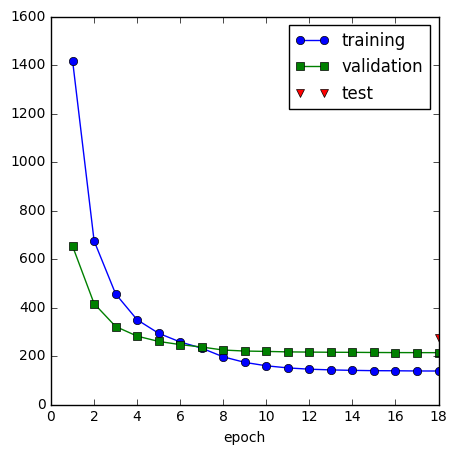

In [8]:
x_max = config.max_max_epoch
fig, ax = pylab.subplots(nrows=1, ncols=1, figsize=(5, 5))
ax.plot(np.arange(1, x_max+1), train_perf, '-o', label="training")
ax.plot(np.arange(1, x_max+1), valid_perf, '-s', label="validation")
ax.plot([x_max], [test_perplexity], 'rv', label="test")
pylab.xlabel('epoch')
pylab.legend(loc='best')
pylab.show()

#### 9. Word2vec
This is a functions to plot word2vec. The result shows similarity of words. An abosolute position in 2-D plane changes if the function runs again, however, relative distances between words are consistent.

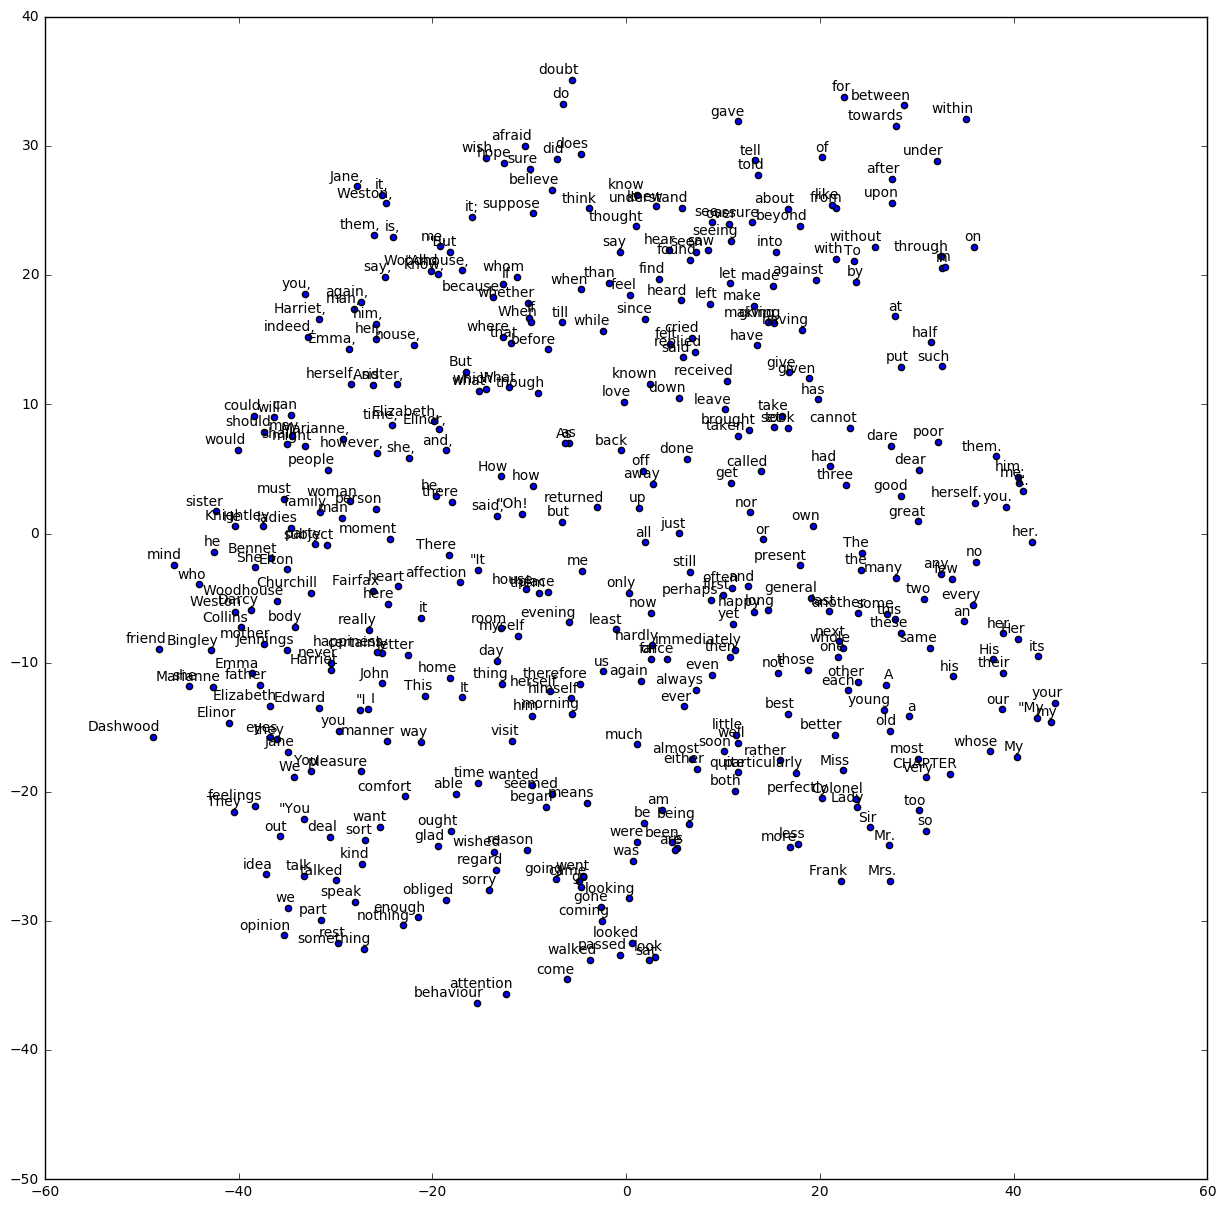

In [10]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2),
                       textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

def draw(embeddings, reverse_dictionary):
    num_points = 400
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])
    words = [reverse_dictionary[i] for i in range(1, num_points+1)]
    plot(two_d_embeddings, words)

reverse_dictionary = dict(zip(word_to_id.values(), word_to_id.keys())) 
draw(final_embeddings, reverse_dictionary)